# Importing relevant data
Based on previous work the edgelist including attributes of textlen and universe is imported into a digraph, and the pandas dataframe containing relevant data is likewise loaded.

In [1]:
#import re
#import urllib.request
#import numpy as np
import pandas as pd
from collections import Counter
import json
import os.path
import networkx as nx
from networkx.readwrite import json_graph
import seaborn as sns

In [2]:
df_superhero = pd.read_csv('df_superhero.csv')
df_superhero.head()

,Unnamed: 0,Unnamed: 0.1,CharacterName,WikiLink,file,universe,WikiOutLinks,TextLen
0,0,0,Abin Sur,['Abin Sur'],Abin_Sur.json,dc,"['Special:ApiFeatureUsage', 'DC Comics', 'John...",5351
1,1,1,Abra Kadabra (character),['Abra Kadabra (character)'],Abra_Kadabra_%28character%29.json,dc,"['Special:ApiFeatureUsage', 'Oscar Jimenez (co...",2740
2,2,2,Abby Holland,['Abby Holland'],Abby_Holland.json,dc,"['Special:ApiFeatureUsage', 'File:SwampThing22...",4446
3,3,3,Ace the Bat-Hound,['Ace the Bat-Hound'],Ace_the_Bat-Hound.json,dc,"['Special:ApiFeatureUsage', 'Detective Comics'...",3294
4,6,6,Adam Strange,['Adam Strange'],Adam_Strange.json,dc,"['Special:ApiFeatureUsage', 'Alex Ross', 'DC C...",7533


In [3]:
G_superhero = nx.DiGraph()

with open(f"supernetwork.json", "r") as infile:
    json_data = json.load(infile)
    G_superhero = json_graph.adjacency_graph(json_data)

#to check if the graph is directed, and attributes are loaded
print(G_superhero.nodes['Animal-Vegetable-Mineral Man'])
print(G_superhero)

{'universe': 'dc', 'textlen': 1362}
DiGraph with 1585 nodes and 21601 edges


# Basic stats

#### Task:
- Write a short paragraph describing the network. The paragraph should contain the following information
- The number of nodes and links.
- The average, median, mode, minimum and maximum value of the network's in-degree.s And of the out-degrees.

In [75]:
in_super = sorted([d for n, d in G_superhero.in_degree()], reverse=True)
out_super = sorted([d for n, d in G_superhero.out_degree()], reverse=True)

print(f'The network has a total number of {len(G_superhero.nodes())} nodes and {G_superhero.number_of_edges()} edges.'+
      f' The average degree is {sum(in_super)/len(in_super)}.'+
        f' The median in-degree is {in_super[len(in_super)//2]} and the median out-degree is {out_super[len(out_super)//2]}.'+
        f' The maximum in-degree is {in_super[0]}, the maximum out-degree is {out_super[0]}.'+
        f' And finally the mode in-degree is {Counter(in_super).most_common(1)[0][0]} and the mode out-degree is {Counter(out_super).most_common(1)[0][0]}.')

The network has a total number of 1585 nodes and 21601 edges. The average degree is 13.62839116719243. The median in-degree is 6 and the median out-degree is 10. The maximum in-degree is 433, the maximum out-degree is 90. And finally the mode in-degree is 1 and the mode out-degree is 6.


The observation that the max in-degree is 433, but the mode in-degree is just 1, tells us that especially on the in-ward connection the network is very uneven with properties that resemble behavior of a highly scale-free network. Outdegrees are distributed more evenly, and in combination with the in-degree, it means that generally nodes have a number of outlinks each, but many of these point to a few central hubs.

### Task: 
We also want the degree distributions and a plot of the network

- Create in- and out-going degree distributions as described in Lecture 5.
- Estimate the slope of the incoming degree distribtion as described in Lecture 5.
- Plot the network using the Force Atlas algorithm as described in Lecture 5.

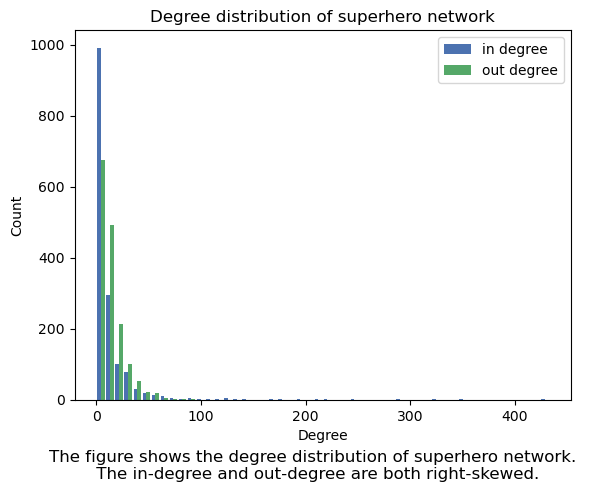

In [53]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

plt.hist([in_super, out_super], bins=50, label=['in degree', 'out degree'])
plt.legend(loc='upper right')
#plt add caption
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Degree distribution of superhero network')
#add description to figure and avoid overlapping xlabel
plt.figtext(0.5, -0.05, 'The figure shows the degree distribution of superhero network. \n The in-degree and out-degree are both right-skewed.', wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

In total the number of in and out degrees must be equal to one another, but there is a higher proportion of nodes with a low in degree, than there are nodes with a low out-degree. It means that it is more common for nodes to have just a few in-connections, and more common to have more out-connections.

This is possible due to a few nodes that have a lot of in-wards links, central hubs like Spiderman, Batman etc. where a lot of other characters link to, but these hubs link less outwards.  

In [51]:
import powerlaw
slope_super = powerlaw.Fit(in_super).alpha
print(f'The slope of the in-degree distribution is {slope_super}')

The slope of the in-degree distribution is 2.519458485615602


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
c:\ProgramData\Anaconda3\envs\socialgraph\lib\site-packages\powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


In [74]:
#Theoretical size of largest hub, assuming k_min = 1
k_max_predicted= np.power(len(G_superhero.nodes()),(1/(slope_super-1)))
print(f'expected largest hub {k_max_predicted}')

#Highest k in the network (in)
print(f'Largest hub in the superhero network {max(in_super)}')


expected largest hub 127.65349397765296
Largest hub in the superhero network 433


A degree exponent of 2.52 imply that the network is in the Scale-Free regime. This predicts a number of features, such as:
- Large number of small degree nodes that connected primarily via a few centrail nodes (hubs) that have an extremely high degree relative to the most common degree size (confirmed via plots)
- hubs are expected in scale-free network, and grow polynomially with network size. In this case the largest node would be expected to have 128 in links, whereas in fact it has 433 making this behavior even closer to 
- the network structure enables the 'ultra small world' property, which imply that the distance from any two nodes in the network is significantly smaller than in a random network


#### Network plot using Force Atlas

In [55]:
#Extracting the giant component of the graph
superhero_subgraphs = [G_superhero.subgraph(
    c).copy() for c in nx.weakly_connected_components(G_superhero)]
GC_superhero = max(superhero_subgraphs, key=len)

#Making the graph unidirectional
GC_super_un = GC_superhero.to_undirected()

#Coloring nodes based on the universe of the character
universe_color = []
for char in GC_super_un.nodes():
    if GC_super_un.nodes[char]['universe'] == 'dc':
        universe_color.append('#034078')
    elif GC_super_un.nodes[char]['universe'] == 'marvel':
        universe_color.append('#ff206e')

#Scaling the size of the nodes relative to their size
degree_list = []
for char in GC_super_un.nodes():
    degree_list.append(GC_super_un.degree(char))

# normalize node size to highest degree with max size = 30
max_degree = max(degree_list)
node_size_list = [x/max_degree*200 for x in degree_list]


100%|██████████| 500/500 [00:22<00:00, 22.49it/s]


BarnesHut Approximation  took  3.63  seconds
Repulsion forces  took  17.74  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.15  seconds
AdjustSpeedAndApplyForces step  took  0.28  seconds


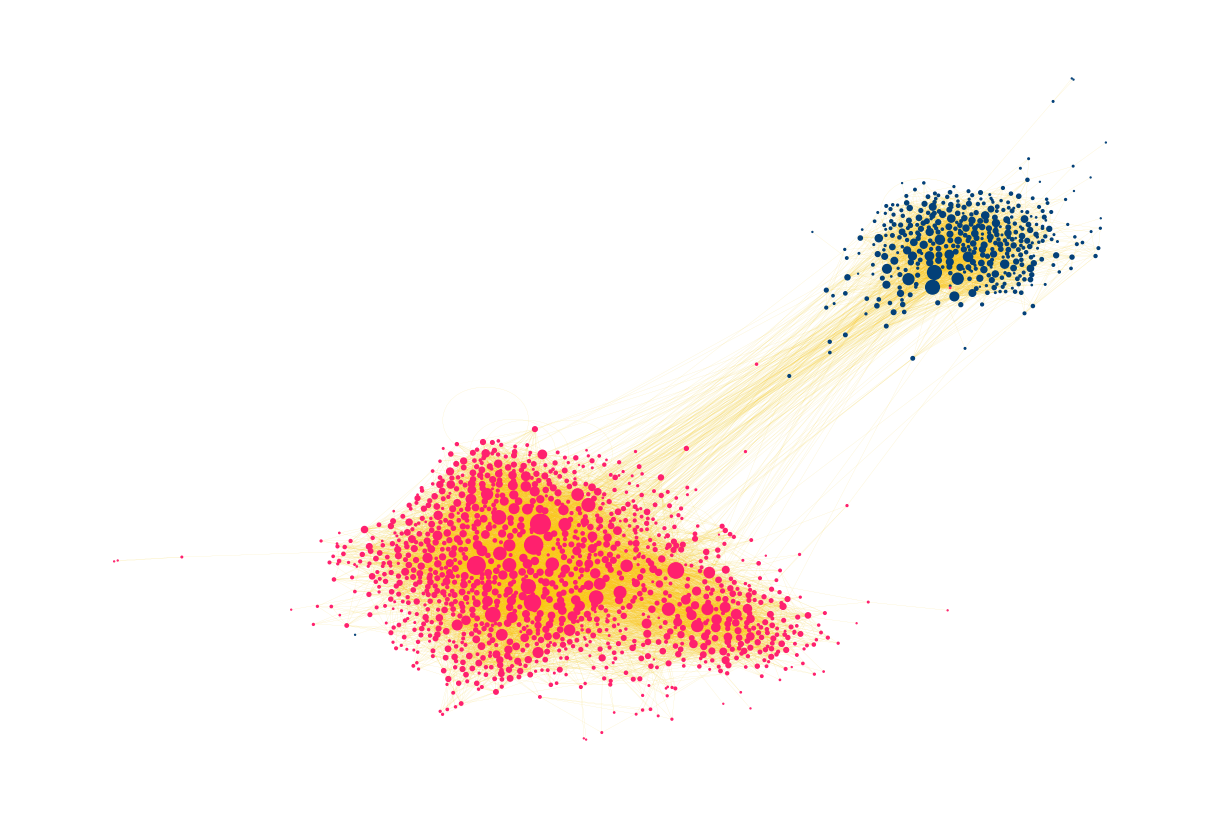

In [56]:
from fa2 import ForceAtlas2

forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=False,  # Dissuade hubs
    linLogMode=False,  # NOT IMPLEMENTED
    adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
    edgeWeightInfluence=1,

    # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=1,
                        strongGravityMode=True,
                        gravity=5,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(
    GC_super_un, pos=None, iterations=500)

plt.figure(figsize=(12, 8))
nx.draw(GC_super_un, pos=positions, with_labels=False, node_size=node_size_list,
        width=0.05, node_color=universe_color, edge_color='#f9c80e')


The split within the marvel universe (red) indicate that there are two 'sub-groupings'. A theory could for example be that there exist a lot of links between avenger characters, originally Iron Man, Captain America, Thor, Hulk, Black Widow and Hawkeye (both movie and comics), and that in a somewhat seperate community the most connected character, Spider-man, has some groupings of his own. Untill 2015 the movie rights for Spiderman was solely Sony's and therefor Spiderman did not appear in any avenger/marvel movies, potentieally limiting the amount of links to other marvel movie characters historically speaking. It could also be that it is another sub-community of super heroes..